In [18]:
# All imports
from regression_analysis.utils import create_data_franke, create_plots, basis_functionality
from regression_analysis.fit_model import ordinary_least_squares, ridge_regression, lasso_regression

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from ipywidgets import interact

In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Ordinary Least Squares

The Ordinary Least Squares (OLS) method is used to estimate the unknown paramters in a linear regression model. 
Suppose our data is made of $n$ obeservations which are given by $(x_i, y_i)_{i=0}^{n-1}$ where $x_i$ is a feature and $y_0$ is the ouput or target. In a linear regressiion model the response variable $y$ is defined as: $$y_i:= \beta_1 x_{i,1}+\beta_2 x_{i,2}+\dots+\beta_p x_{i,p}+\epsilon_i.$$ This can also be written in matrix notation as $y:=X\beta+\epsilon.$ $X$ is called the design matrix. 

The aim of OLS is to find the optimal $\beta_{OLS}$ which minimizes the cost function $$C_{OLS}(\beta):=\frac{1}{n}\sum_{i=0}^{n-1}(y_i-\sum_{j=0}^{p-1}x_{ij}\beta_j)^2.$$ This $\beta_{OLS}$ can be calculated as follows $$\beta_{OLS}=\underset{\beta \in R^p}{\arg\max}\frac{1}{n}(y-X\beta)^T(y-X\beta)=(X^TX)^{-1}X^Ty.$$



## Data

The Franke function is used to generate the data:

$$y(x_1,x_2) = \frac{3}{4}\exp{(-\frac{(9x_1-2)^2}{4}-\frac{(9x_2-2)^2}{4})} + \frac{3}{4}\exp{(-\frac{(9x_1+1)^2}{49}-\frac{(9x_2+1)}{10})} + \frac{1}{2}\exp{(-\frac{(9x_1-7)^2}{4}-\frac{(9x_2-3)^2}{4})} - \frac{1}{5}\exp{(-(9x_1-4)^2-(9x_2-7)^2 )}$$

and $x_1, x_2 \in [0,1]$. This is a two-dimensional function. It is often used as a test function for interpolation and fitting problems.

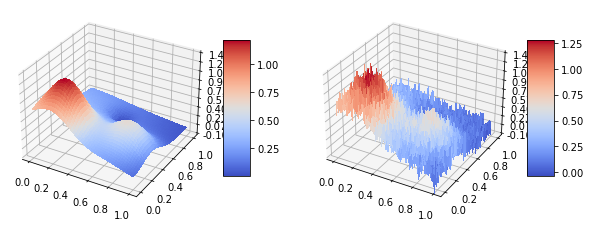

In [20]:
# Generate data without noise
x1, x2, y = create_data_franke.generate_data(noisy=False, points=100)

# Generate data with noise
_, _, y_noise = create_data_franke.generate_data(noisy=True, noise_variance=0.1, points=100)

# Plot data
fig = plt.figure(figsize=(10,5))
fig.tight_layout()
create_plots.make_3d_surface_plot(x1, x2, y, fig=fig, position=121)
create_plots.make_3d_surface_plot(x1, x2, y_noise, fig=fig, position=122)

## Calculate Ordinary Least Squares for order 1
We want to find the best $\beta_{OLS}$ such that $\tilde{y}=X\beta_{OLS}$ where $X$ is the design matrix. $X$'s columns are different combination of the input variables $x_1$ and $x_2$. 
For example when we want to fit a plynomial with the order 2 to $y$ the design matrix has the columns: $1, x, y, xy, x^2, y^2$. 

The following plot shows the fit of a ploynomial with order 1 to the Franke function data. Just by inspecting the plots we can clearly see that this is not a good fit.

In [21]:
def visualize_simple_OLS(noise):
    # Specify if y with or without noise will be used
    if noise=='yes':
        input_y = y_noise
    else:
        input_y = y    
    # Calculate beta and the response variable y_tilde for ordinary least squares.
    beta_OLS, y_tilde_OLS = ordinary_least_squares.calculate_OLS(x1, x2, input_y, order=1)

    # Make plots
    fig = plt.figure(figsize=(10,5))
    fig.tight_layout()
    create_plots.make_3d_surface_plot(x1, x2, input_y, fig=fig, position=121)
    create_plots.make_3d_surface_plot(x1, x2, y_tilde_OLS, fig=fig, position=122)
    
# Create widget
interact(visualize_simple_OLS, noise=['no', 'yes'])

interactive(children=(Dropdown(description='noise', options=('no', 'yes'), value='no'), Output()), _dom_classe…

<function __main__.visualize_simple_OLS(noise)>

Usually we would not look at the plot to decide if the model is good fit. Instead we calculate:
1. **mean squared error (MSE)**: 
The MSE gives the average square difference bewteen the estimated values and the actual value. It is defined as $$MSE:=\frac{1}{n}\sum_{i=0}^{n-1}(y-\tilde{y})^2.$$
2. **$R^2$ score**: The $R^2$ score a measure of how well the model fits the data points. A $R^2$ score of 1 means that the model fits the data perfectly. It is defined as $$R^2:=1-\frac{\sum_{i=0}^{n-1}(y_i-\tilde{y})^2}{\sum_{i=0}^{n-1}(y_i-\bar{y})^2}$$ where $\bar{y}:=\frac{1}{n}\sum_{i=0}^{n-1}y_i$ is the mean value. 

In [22]:
# Calculate beta and the response variable y_tilde for ordinary least squares.
_, y_tilde_OLS = ordinary_least_squares.calculate_OLS(x1, x2, y, order=1)
    
# Calculate error evaluaters for the test dataset
error_class = basis_functionality.Error_Measures(y, y_tilde_OLS)
MSE = error_class.mean_squared_error()
R2 = error_class.r2_score()

print("MSE:" + str(MSE))
print("R2:" + str(R2))

MSE:0.023352654015282418
R2:0.7164398072188657


## How to choose the order of the fitted polynomial

As we have seen fitting a model of order 1 to the Franke data. Therefore, we want to find out which order makes more sense. Moreover, we split the data into testing and training data and the data is scaled using min-max normalization. 

In [23]:
def choose_model_order(noise):
    
    # Specify if y with or without noise will be used
    if noise=='yes':
        input_y = y_noise
    else:
        input_y = y
        
    max_order = 12
    orders = range(1, max_order+1)

    MSE_train = np.empty([1, max_order])
    R2_train = np.empty([1, max_order])
    MSE_test = np.empty([1, max_order])
    R2_test = np.empty([1, max_order])

    for i, order in enumerate(orders):
        MSE_train[:, i], MSE_test[:, i], R2_train[:, i], R2_test[:, i] = ordinary_least_squares.perform_OLS(x1, x2, input_y, order, train_frac=0.8)
    # Plot errors
    fig_errors = plt.figure(figsize=(15,5))
    fig_errors.tight_layout()

    axes_1 = np.array(orders)

    args_MSE = (MSE_train, MSE_test)
    axes_MSE_2 = np.concatenate(args_MSE, axis=0)
    line_lab_MSE = ['MSE train', 'MSE test']

    create_plots.make_multi_line_plot(axes_1, axes_MSE_2, line_lab_MSE, fig_errors, 121, [0, 0.0175])

    args_R2 = (R2_train, R2_test)
    axes_R2_2 = np.concatenate(args_R2, axis=0)
    line_lab_R2 = ['R2 train', 'R2 test']

    create_plots.make_multi_line_plot(axes_1, axes_R2_2, line_lab_R2, fig_errors, 122, [0.7, 1.01])
    

    plt.show()
    
# Create widget
interact(choose_model_order, noise=['no', 'yes'])

interactive(children=(Dropdown(description='noise', options=('no', 'yes'), value='no'), Output()), _dom_classe…

<function __main__.choose_model_order(noise)>

We see clearly that for an order higher than 8 either the fit gets worse or stays nearly the same. Therefore, in the following we will consider orders up to 8.

The MSE can also be written as the sum of the bias and the variance. Moreover, it can be shown that when the model complexity is increased the variance increases aswell but the suqared bias decreases. When the model complexity is decreases the opposite happens, i.e. the variance decreases and the squared bias increases. We want to choose our model/ order with the best bias variance tradeoff in such a way that the test error is minimized.

The polynomial order is in this case also the model complexity.

Let's have a closer look at the bias and variance.

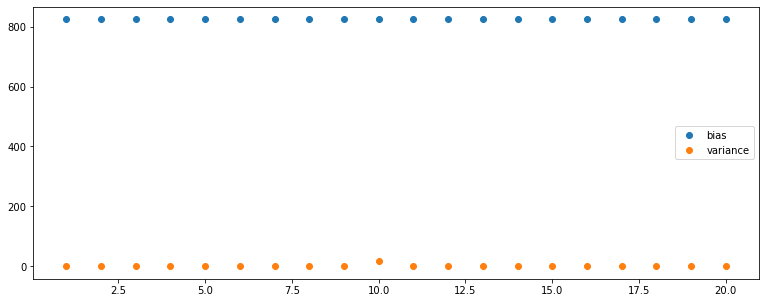

In [24]:
# Calculate beta and the response variable y_tilde for ordinary least squares.
max_order = 20
orders = range(1, max_order+1)

MSE = np.empty(max_order)
bias = np.empty(max_order)
variance = np.empty(max_order)

for index, order in enumerate(orders):
    _, y_tilde_OLS = ordinary_least_squares.calculate_OLS(x1, x2, y, order=order)

    # Calculate MSE, bias and variance
    error_measures = basis_functionality.Error_Measures(y, y_tilde_OLS)
    bias[index] = error_measures.bias()
    variance[index] = error_measures.variance()

# Make plot
fig = plt.figure(figsize=(13,5))
fig.tight_layout()

ax = fig.add_subplot()
ax.plot(orders, bias, 'o', label='bias')
ax.plot(orders, variance, 'o', label='variance')

ax.legend()

## Resampling algorithms

In the following we have a closer look at resampling techniques. To do this we use the train_test_split function from scikit-learn to split the data in testing and training data and compare the fit with results after applying bootstrapping or cross-validation. 

In [25]:
# Set max order for the following code
max_order = 8
orders = range(1, max_order+1)

In [26]:
# Fit model with different resampling techniques and different orders
def fit_model_resampling(noise):
    
    # Specify if y with or without noise will be used
    if noise=='yes':
        input_y = y_noise
    else:
        input_y = y
        
    MSE_train, MSE_test = np.empty([1, max_order]), np.empty([1, max_order])
    R2_train, R2_test = np.empty([1, max_order]), np.empty([1, max_order])

    MSE_train_c, MSE_test_c = np.empty([1, max_order]), np.empty([1, max_order])
    R2_train_c, R2_test_c = np.empty([1, max_order]), np.empty([1, max_order])

    MSE_train_b, MSE_test_b = np.empty([1, max_order]), np.empty([1, max_order])
    R2_train_b, R2_test_b = np.empty([1, max_order]), np.empty([1, max_order])

    for i, order in enumerate(orders):
        MSE_train[:, i], MSE_test[:, i], R2_train[:, i], R2_test[:, i] = ordinary_least_squares.perform_OLS(x1, x2, input_y, order, train_frac=0.8)
        MSE_train_c[:, i], MSE_test_c[:, i], R2_train_c[:, i], R2_test_c[:, i] = ordinary_least_squares.perform_OLS_cross_val(x1, x2, input_y, order, num_fold=5)
        MSE_train_b[:, i], MSE_test_b[:, i], R2_train_b[:, i], R2_test_b[:, i] = ordinary_least_squares.perform_OLS_bootstrap(x1, x2, input_y, order, train_frac=0.8, num_boot=10)
        
    return  (MSE_train, MSE_test, MSE_train_c, MSE_test_c, MSE_train_b, MSE_test_b), (R2_train, R2_test, R2_train_c, R2_test_c, R2_train_b, R2_test_b)

In [27]:
def plot_errors_resampling(noise):
    
    args_MSE, args_R2 = fit_model_resampling(noise)
    # Plot errors
    axes_1 = np.array(orders)
    axes_MSE_2 = np.concatenate(args_MSE, axis=0)
    axes_R2_2 = np.concatenate(args_R2, axis=0)

    line_lab_MSE = ['MSE train', 'MSE test', 'MSE_train_c', 'MSE_test_c', 'MSE_train_b', 'MSE_test_b']
    line_lab_R2 = ['R2 train', 'R2 test', 'R2_train_c', 'R2_test_c', 'R2_train_b', 'R2_test_b']

    fig_errors = plt.figure(figsize=(15,10))
    fig_errors.tight_layout()
    create_plots.make_multi_line_plot(axes_1, axes_MSE_2[0::2], line_lab_MSE[0::2], fig_errors, 221, [0, 0.02])
    create_plots.make_multi_line_plot(axes_1, axes_R2_2[0::2], line_lab_R2[0::2], fig_errors, 223, [0.7, 1])
    create_plots.make_multi_line_plot(axes_1, axes_MSE_2[1::2], line_lab_MSE[1::2], fig_errors, 222, [0, 0.02])
    create_plots.make_multi_line_plot(axes_1, axes_R2_2[1::2], line_lab_R2[1::2], fig_errors, 224, [0.7, 1])

    plt.show()
    
# Create widget
interact(plot_errors_resampling, noise=['no', 'yes'])

interactive(children=(Dropdown(description='noise', options=('no', 'yes'), value='no'), Output()), _dom_classe…

<function __main__.plot_errors_resampling(noise)>

### Influence of parameters in resampling methods

Each resampling algorithm depends in different parameters. We want to figure out how many folds are necessary to have a good fit when using crossvalidation and similarly how often bootstrapping should be repeated.

Start by defining a function which creates a heatmap from a pandas dataframe.

In [28]:
def create_heatmap(data, axis, title=None, c_min=0.001, c_max=0.02):
    """
    Creates a heatmap from a pandas dataframe.
    Inspired by: https://www.geeksforgeeks.org/display-the-pandas-dataframe-in-heatmap-style/
    """
    # Reverse order of dataframe index
    data = data.sort_index(ascending=False)
    # Displaying dataframe as an heatmap
    sns.heatmap(data, linewidths = 0.30, annot = True, cmap="mako", ax=axis, vmin=c_min, vmax=c_max).set_title(title)

#### Influence of the number of folds when using cross-validation

In [29]:
# Fit model for different polynomial orders and different amount of folds
cross_val_folds = range(2, 11)

MSE_train = np.empty([len(cross_val_folds), max_order])
MSE_test = np.empty([len(cross_val_folds), max_order])


for folds_idx, n_folds in enumerate(cross_val_folds):
    for order_idx, order in enumerate(orders):
        MSE_train[folds_idx, order_idx], MSE_test[folds_idx, order_idx], _, _ = ordinary_least_squares.perform_OLS_cross_val(x1, x2, y, order, num_fold=n_folds)

MSE_train_cross_df = pd.DataFrame(data=MSE_train, index=cross_val_folds, columns=orders)
MSE_test_cross_df = pd.DataFrame(data=MSE_test, index=cross_val_folds, columns=orders)

print("MSE training data:")
display(MSE_train_cross_df)
print("MSE test data:")
display(MSE_test_cross_df)

MSE training data:


,1,2,3,4,5,6,7,8
2,0.015729,0.011467,0.005248,0.002742,0.001401,0.000776,0.000389,0.000205
3,0.015735,0.011473,0.005249,0.002745,0.001400,0.000777,0.000391,0.000208
4,0.015735,0.011474,0.005249,0.002745,0.001401,0.000779,0.000391,0.000208
5,0.015736,0.011474,0.005250,0.002745,0.001402,0.000779,0.000391,0.000208
6,0.015735,0.011473,0.005250,0.002745,0.001402,0.000779,0.000391,0.000208
7,0.015735,0.011474,0.005251,0.002746,0.001402,0.000779,0.000391,0.000208
8,0.015736,0.011475,0.005251,0.002745,0.001402,0.000779,0.000391,0.000208
9,0.015737,0.011475,0.005251,0.002746,0.001402,0.000779,0.000391,0.000208
10,0.015736,0.011475,0.005251,0.002746,0.001402,0.000779,0.000391,0.000208


MSE test data:


,1,2,3,4,5,6,7,8
2,0.015759,0.011503,0.005260,0.002759,0.001407,0.000791,0.000398,0.000220
3,0.015746,0.011487,0.005262,0.002754,0.001414,0.000791,0.000395,0.000213
4,0.015751,0.011490,0.005269,0.002754,0.001412,0.000787,0.000396,0.000212
5,0.015744,0.011489,0.005264,0.002757,0.001409,0.000786,0.000397,0.000212
6,0.015759,0.011499,0.005261,0.002763,0.001410,0.000786,0.000395,0.000212
7,0.015754,0.011493,0.005262,0.002756,0.001413,0.000788,0.000395,0.000212
8,0.015751,0.011485,0.005261,0.002760,0.001413,0.000786,0.000394,0.000213
9,0.015745,0.011484,0.005262,0.002757,0.001414,0.000786,0.000396,0.000212
10,0.015751,0.011487,0.005265,0.002758,0.001412,0.000786,0.000396,0.000212


#### Influence of train fraction in scikit-learn function

In [30]:
# Fit model for different polynomial orders and different train fractions, no boostrapping
train_frac = np.round(np.arange(0.75, 1, 0.05), 2)

MSE_train = np.empty([len(train_frac), max_order])
MSE_test = np.empty([len(train_frac), max_order])


for frac_idx, frac in enumerate(train_frac):
    for order_idx, order in enumerate(orders):
        MSE_train[frac_idx, order_idx], MSE_test[frac_idx, order_idx], _, _ = ordinary_least_squares.perform_OLS(x1, x2, y, order, train_frac=frac)

MSE_train_frac_df = pd.DataFrame(data=MSE_train, index=train_frac, columns=orders)
MSE_test_frac_df = pd.DataFrame(data=MSE_test, index=train_frac, columns=orders)

print("MSE training data:")
display(MSE_train_frac_df)
print("MSE test data:")
display(MSE_test_frac_df)

MSE training data:


,1,2,3,4,5,6,7,8
0.75,0.014623,0.011584,0.005566,0.002594,0.001379,0.000792,0.000371,0.000217
0.80,0.015466,0.011101,0.005001,0.002808,0.001397,0.000782,0.000375,0.000214
0.85,0.015577,0.011521,0.005264,0.002754,0.001401,0.000696,0.000386,0.000211
0.90,0.015364,0.011773,0.005525,0.002759,0.001420,0.000778,0.000395,0.000205
0.95,0.015450,0.011403,0.005210,0.002766,0.001396,0.000785,0.000399,0.000206


MSE test data:


,1,2,3,4,5,6,7,8
0.75,0.019664,0.011333,0.004334,0.003287,0.001489,0.000768,0.000477,0.000192
0.80,0.016890,0.013105,0.006326,0.002523,0.001457,0.000777,0.000475,0.000199
0.85,0.016650,0.011268,0.005209,0.002878,0.001432,0.001755,0.000440,0.000222
0.90,0.019245,0.008964,0.002822,0.002668,0.001266,0.000836,0.000401,0.000247
0.95,0.021379,0.012966,0.006041,0.002406,0.001548,0.000685,0.000265,0.000261


#### Influence of number of repitions of bootstraps

In [31]:
# Fit model for different polynomial orders and boostrapping
boots = range(5, 11)

MSE_train = np.empty([len(boots), max_order])
MSE_test = np.empty([len(boots), max_order])


for boot_idx, num_boot in enumerate(boots):
    for order_idx, order in enumerate(orders):
        MSE_train[boot_idx, order_idx], MSE_test[boot_idx, order_idx], _, _ = ordinary_least_squares.perform_OLS_bootstrap(x1, x2, y, order, train_frac=0.8, num_boot=num_boot)

MSE_train_boot_df = pd.DataFrame(data=MSE_train, index=boots, columns=orders)
MSE_test_boot_df = pd.DataFrame(data=MSE_test, index=boots, columns=orders)

print("MSE training data:")
display(MSE_train_boot_df)
print("MSE test data:")
display(MSE_test_boot_df)

MSE training data:


,1,2,3,4,5,6,7,8
5,0.015997,0.010983,0.005320,0.002691,0.001325,0.000784,0.000379,0.000213
6,0.014886,0.011323,0.004932,0.002692,0.001400,0.000726,0.000400,0.000191
7,0.016313,0.011212,0.005211,0.002738,0.001297,0.000763,0.000378,0.000205
8,0.016134,0.011219,0.005227,0.002647,0.001297,0.000780,0.000372,0.000203
9,0.016622,0.010782,0.005076,0.002768,0.001416,0.000785,0.000409,0.000205
10,0.016006,0.011284,0.004888,0.002739,0.001421,0.000760,0.000394,0.000209


MSE test data:


,1,2,3,4,5,6,7,8
5,0.015298,0.014275,0.004940,0.003096,0.001845,0.000799,0.000427,0.000219
6,0.019392,0.011815,0.006617,0.003342,0.001416,0.001059,0.000361,0.000280
7,0.013010,0.012307,0.005497,0.002649,0.001868,0.000939,0.000432,0.000210
8,0.014248,0.012226,0.005318,0.003638,0.001933,0.000772,0.000520,0.000243
9,0.012699,0.014728,0.005965,0.002726,0.001419,0.000752,0.000337,0.000229
10,0.014909,0.012204,0.006761,0.002787,0.001374,0.000871,0.000381,0.000216


Make comparison between different sampling methods

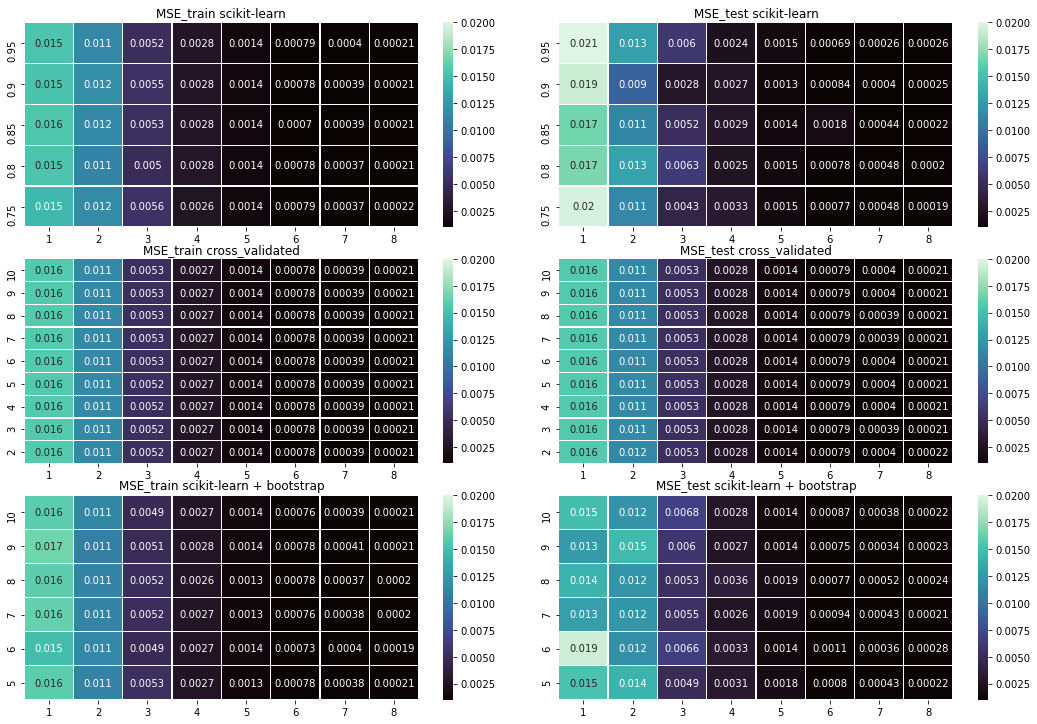

In [32]:
fig, ax = plt.subplots(3,2,figsize=(15,10))
fig.tight_layout()

# Sklearn splitting in train9ing and testing data (without bootstrap)
create_heatmap(MSE_train_frac_df, title="MSE_train scikit-learn", axis=ax[0][0])
create_heatmap(MSE_test_frac_df, title="MSE_test scikit-learn", axis=ax[0][1])

# Cross-validated data
create_heatmap(MSE_train_cross_df, title="MSE_train cross_validated", axis=ax[1][0])
create_heatmap(MSE_test_cross_df, title="MSE_test cross_validated", axis=ax[1][1])

# Bootstrapped data
create_heatmap(MSE_train_boot_df, title="MSE_train scikit-learn + bootstrap", axis=ax[2][0])
create_heatmap(MSE_test_boot_df, title="MSE_test scikit-learn + bootstrap", axis=ax[2][1])

# Ridge Regression

## Compare fit with Ridge Regression and Odinary Least Squares

In [33]:
def visualize_simple_fit_OLS_RR(noise):
    # Specify if y with or without noise will be used
    if noise=='yes':
        input_y = y_noise
    else:
        input_y = y    
    # Calculate the response variable y_tilde for ordinary least squares.
    _, y_tilde_OLS = ordinary_least_squares.calculate_OLS(x1, x2, input_y, order=8)
    # Calculate the response variable y_tilde for ridge regression.
    _, y_tilde_RR = ridge_regression.calculate_RR(x1, x2, input_y, order=8, lam=0.01)

    # Make plots
    fig = plt.figure(figsize=(15,5))
    fig.tight_layout()
    create_plots.make_3d_surface_plot(x1, x2, input_y, fig=fig, position=131)
    create_plots.make_3d_surface_plot(x1, x2, y_tilde_OLS, fig=fig, position=132)
    create_plots.make_3d_surface_plot(x1, x2, y_tilde_RR, fig=fig, position=133)
    
# Create widget
interact(visualize_simple_fit_OLS_RR, noise=['no', 'yes'])

interactive(children=(Dropdown(description='noise', options=('no', 'yes'), value='no'), Output()), _dom_classe…

<function __main__.visualize_simple_fit_OLS_RR(noise)>

### Dependence on $\lambda$

In [34]:
# Specify which lambdas are used
lambda_range = np.round(np.arange(0, 0.01, 0.001), 3)

In [35]:
def fit_cross_val_RR(noise):
    """
    Fits Ridge Regression with different lamdas. 
    Cross_validation is used as a resampling method.
    """
    
    # Specify if y with or without noise will be used
    if noise=='yes':
        input_y = y_noise
    else:
        input_y = y 
    
    # Specify how many folds are used
    cross_val_folds = range(2, 11)

    # Create empty placeholders for MSE
    MSE_train, MSE_test = np.empty([len(cross_val_folds), len(lambda_range)]), np.empty([len(cross_val_folds), len(lambda_range)])

    for folds_idx, n_folds in enumerate(cross_val_folds):
        for lambda_idx, lam in enumerate(lambda_range):
            MSE_train[folds_idx, lambda_idx], MSE_test[folds_idx, lambda_idx], _, _ = ridge_regression.perform_RR_cross_val(x1, x2, input_y, order=8, lam=lam, num_fold=n_folds)

    MSE_train_cross_df = pd.DataFrame(data=MSE_train, index=cross_val_folds, columns=lambda_range)
    MSE_test_cross_df = pd.DataFrame(data=MSE_test, index=cross_val_folds, columns=lambda_range)
    
    return MSE_train_cross_df, MSE_test_cross_df

In [36]:
def fit_bootstrap_RR(noise):
    """
    Fits Ridge Regression with different lamdas. 
    Bootstrap is used as a resampling method.
    """
    
    # Specify if y with or without noise will be used
    if noise=='yes':
        input_y = y_noise
    else:
        input_y = y 
        
    # Specify how often boostrapping is performed
    boots = range(5, 11)

    # Create empty placeholders for MSE
    MSE_train, MSE_test = np.empty([len(boots), len(lambda_range)]), np.empty([len(boots), len(lambda_range)])

    for boot_idx, num_boot in enumerate(boots):
        for lambda_idx, lam in enumerate(lambda_range):
            MSE_train[boot_idx, lambda_idx], MSE_test[boot_idx, lambda_idx], _, _ = ridge_regression.perform_RR_bootstrap(x1, x2, input_y, order=8, lam=lam, train_frac=0.8, num_boot=num_boot)

    MSE_train_boot_df = pd.DataFrame(data=MSE_train, index=boots, columns=lambda_range)
    MSE_test_boot_df = pd.DataFrame(data=MSE_test, index=boots, columns=lambda_range)
    
    return MSE_train_boot_df, MSE_test_boot_df

In [37]:
def fit_scikit_RR(noise):
    """
    Fits Ridge Regression with different lamdas. 
    The scikit test_train_split function with different sizes for the training data is used.
    """
    
    # Specify if y with or without noise will be used
    if noise=='yes':
        input_y = y_noise
    else:
        input_y = y 
        
    # Specify which train fractions are used
    train_frac = np.round(np.arange(0.75, 1, 0.05), 2)

    # Create empty placeholders for MSE
    MSE_train, MSE_test = np.empty([len(train_frac), len(lambda_range)]), np.empty([len(train_frac), len(lambda_range)])

    for frac_idx, frac in enumerate(train_frac):
        for lambda_idx, lam in enumerate(lambda_range):
            MSE_train[frac_idx, lambda_idx], MSE_test[frac_idx, lambda_idx], _, _ = ridge_regression.perform_RR(x1, x2, input_y, order=8, lam=lam, train_frac=0.8)

    MSE_train_frac_df = pd.DataFrame(data=MSE_train, index=train_frac, columns=lambda_range)
    MSE_test_frac_df = pd.DataFrame(data=MSE_test, index=train_frac, columns=lambda_range)
    
    return MSE_train_frac_df, MSE_test_frac_df

In [38]:
def compare_resampling_RR(noise):
    """Creates heatmaps to compare fit with Ridge Regression with different lamdas and resampling techniques."""
    # Get MSE for different resampling methods
    MSE_train_cross_df, MSE_test_cross_df = fit_cross_val_RR(noise)
    MSE_train_boot_df, MSE_test_boot_df = fit_bootstrap_RR(noise)
    MSE_train_frac_df, MSE_test_frac_df = fit_scikit_RR(noise)
    
    # Create figure
    fig, ax = plt.subplots(3,2,figsize=(15,10))
    fig.tight_layout()

    # Sklearn splitting in training and testing data
    create_heatmap(MSE_train_frac_df, title="MSE_train scikit-learn", axis=ax[0][0], c_min=0, c_max=0.0017)
    create_heatmap(MSE_test_frac_df, title="MSE_test scikit-learn", axis=ax[0][1], c_min=0, c_max=0.0017)

    # Cross-validated data
    create_heatmap(MSE_train_cross_df, title="MSE_train cross_validated", axis=ax[1][0], c_min=0, c_max=0.0017)
    create_heatmap(MSE_test_cross_df, title="MSE_test cross_validated", axis=ax[1][1], c_min=0, c_max=0.0017)

    # Bootstrapped data
    create_heatmap(MSE_train_boot_df, title="MSE_train scikit-learn + bootstrap", axis=ax[2][0], c_min=0, c_max=0.0017)
    create_heatmap(MSE_test_boot_df, title="MSE_test scikit-learn + bootstrap", axis=ax[2][1], c_min=0, c_max=0.0017)
    
# Create widget
interact(compare_resampling_RR, noise=['no', 'yes'])

interactive(children=(Dropdown(description='noise', options=('no', 'yes'), value='no'), Output()), _dom_classe…

<function __main__.compare_resampling_RR(noise)>

# Lasso Regression

## Compare fit with Lasso Regression, Ridge Regression and Odinary Least Squares

In [39]:
def visualize_simple_fit_OLS_RR_LR(noise):
    # Specify if y with or without noise will be used
    if noise=='yes':
        input_y = y_noise
    else:
        input_y = y    
    # Calculate the response variable y_tilde for ordinary least squares.
    _, y_tilde_OLS = ordinary_least_squares.calculate_OLS(x1, x2, input_y, order=8)
    # Calculate the response variable y_tilde for ridge regression.
    _, y_tilde_RR = ridge_regression.calculate_RR(x1, x2, input_y, order=8, lam=0.001)
    # Calculate the response variable y_tilde for lasso regression.
    _, y_tilde_LR = lasso_regression.calculate_LR(x1, x2, input_y, order=8, lam=0.001)

    # Make plots
    fig = plt.figure(figsize=(15,5))
    fig.tight_layout()
    create_plots.make_3d_surface_plot(x1, x2, input_y, fig=fig, position=221)
    create_plots.make_3d_surface_plot(x1, x2, y_tilde_OLS, fig=fig, position=222)
    create_plots.make_3d_surface_plot(x1, x2, y_tilde_RR, fig=fig, position=223)
    create_plots.make_3d_surface_plot(x1, x2, y_tilde_LR, fig=fig, position=224)
    
# Create widget
interact(visualize_simple_fit_OLS_RR_LR, noise=['no', 'yes'])

interactive(children=(Dropdown(description='noise', options=('no', 'yes'), value='no'), Output()), _dom_classe…

<function __main__.visualize_simple_fit_OLS_RR_LR(noise)>

### Dependence on $\lambda$

In [40]:
# Specify which lambdas are used
lambda_range = np.round(np.arange(0.001, 0.01, 0.001), 3)

In [41]:
def fit_cross_val_LR(noise):
    """
    Fits Lasso Regression with different lamdas. 
    Cross_validation is used as a resampling method.
    """
    
    # Specify if y with or without noise will be used
    if noise=='yes':
        input_y = y_noise
    else:
        input_y = y 
    
    # Specify how many folds are used
    cross_val_folds = range(2, 11)

    # Create empty placeholders for MSE
    MSE_train, MSE_test = np.empty([len(cross_val_folds), len(lambda_range)]), np.empty([len(cross_val_folds), len(lambda_range)])

    for folds_idx, n_folds in enumerate(cross_val_folds):
        for lambda_idx, lam in enumerate(lambda_range):
            MSE_train[folds_idx, lambda_idx], MSE_test[folds_idx, lambda_idx], _, _ = lasso_regression.perform_LR_cross_val(x1, x2, input_y, order=8, lam=lam, num_fold=n_folds)

    MSE_train_cross_df = pd.DataFrame(data=MSE_train, index=cross_val_folds, columns=lambda_range)
    MSE_test_cross_df = pd.DataFrame(data=MSE_test, index=cross_val_folds, columns=lambda_range)
    
    return MSE_train_cross_df, MSE_test_cross_df

In [42]:
def fit_bootstrap_LR(noise):
    """
    Fits Lasso Regression with different lamdas. 
    Bootstrap is used as a resampling method.
    """
    
    # Specify if y with or without noise will be used
    if noise=='yes':
        input_y = y_noise
    else:
        input_y = y 
        
    # Specify how often boostrapping is performed
    boots = range(5, 11)

    # Create empty placeholders for MSE
    MSE_train, MSE_test = np.empty([len(boots), len(lambda_range)]), np.empty([len(boots), len(lambda_range)])

    for boot_idx, num_boot in enumerate(boots):
        for lambda_idx, lam in enumerate(lambda_range):
            MSE_train[boot_idx, lambda_idx], MSE_test[boot_idx, lambda_idx], _, _ = lasso_regression.perform_LR_bootstrap(x1, x2, input_y, order=8, lam=lam, train_frac=0.8, num_boot=num_boot)

    MSE_train_boot_df = pd.DataFrame(data=MSE_train, index=boots, columns=lambda_range)
    MSE_test_boot_df = pd.DataFrame(data=MSE_test, index=boots, columns=lambda_range)
    
    return MSE_train_boot_df, MSE_test_boot_df

In [43]:
def fit_scikit_LR(noise):
    """
    Fits Lasso Regression with different lamdas. 
    The scikit test_train_split function with different sizes for the training data is used.
    """
    
    # Specify if y with or without noise will be used
    if noise=='yes':
        input_y = y_noise
    else:
        input_y = y 
        
    # Specify which train fractions are used
    train_frac = np.round(np.arange(0.75, 1, 0.05), 2)

    # Create empty placeholders for MSE
    MSE_train, MSE_test = np.empty([len(train_frac), len(lambda_range)]), np.empty([len(train_frac), len(lambda_range)])

    for frac_idx, frac in enumerate(train_frac):
        for lambda_idx, lam in enumerate(lambda_range):
            MSE_train[frac_idx, lambda_idx], MSE_test[frac_idx, lambda_idx], _, _ = lasso_regression.perform_LR(x1, x2, input_y, order=8, lam=lam, train_frac=0.8)

    MSE_train_frac_df = pd.DataFrame(data=MSE_train, index=train_frac, columns=lambda_range)
    MSE_test_frac_df = pd.DataFrame(data=MSE_test, index=train_frac, columns=lambda_range)
    
    return MSE_train_frac_df, MSE_test_frac_df

In [44]:
def compare_resampling_RR(noise):
    """Creates heatmaps to compare fit with Lasso Regression with different lamdas and resampling techniques."""
    # Get MSE for different resampling methods
    MSE_train_cross_df, MSE_test_cross_df = fit_cross_val_LR(noise)
    MSE_train_boot_df, MSE_test_boot_df = fit_bootstrap_LR(noise)
    MSE_train_frac_df, MSE_test_frac_df = fit_scikit_LR(noise)
    
    # Create figure
    fig, ax = plt.subplots(3,2,figsize=(15,10))
    fig.tight_layout()

    # Sklearn splitting in training and testing data
    create_heatmap(MSE_train_frac_df, title="MSE_train scikit-learn", axis=ax[0][0], c_min=0.009, c_max=0.025)
    create_heatmap(MSE_test_frac_df, title="MSE_test scikit-learn", axis=ax[0][1], c_min=0.009, c_max=0.025)

    # Cross-validated data
    create_heatmap(MSE_train_cross_df, title="MSE_train cross_validated", axis=ax[1][0], c_min=0.009, c_max=0.025)
    create_heatmap(MSE_test_cross_df, title="MSE_test cross_validated", axis=ax[1][1], c_min=0.009, c_max=0.025)

    # Bootstrapped data
    create_heatmap(MSE_train_boot_df, title="MSE_train scikit-learn + bootstrap", axis=ax[2][0], c_min=0.009, c_max=0.025)
    create_heatmap(MSE_test_boot_df, title="MSE_test scikit-learn + bootstrap", axis=ax[2][1], c_min=0.009, c_max=0.025)
    
# Create widget
interact(compare_resampling_RR, noise=['no', 'yes'])

interactive(children=(Dropdown(description='noise', options=('no', 'yes'), value='no'), Output()), _dom_classe…

<function __main__.compare_resampling_RR(noise)>